In [15]:
import nltk
import urllib
import bs4 as bs
import re
from gensim.models import Word2Vec
from gensim.models.word2vec import Text8Corpus
from gensim.models import word2vec
from nltk.corpus import stopwords
import pandas as pd
import gzip
import json
import gensim.downloader as api
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
import logging
from multiprocessing import cpu_count
import string
import train_models_word2vec as LocalFile
from os.path import exists
import matplotlib.pyplot as plt

# Declaração

In [5]:
#Declaração
STOP_WORDS = stopwords.words('english')
PUNCTUATION = ['!','"','#','$','%','&','\/','(',')','*','+',',','-','.','/',':',';','<','=','>','?','@','[',']','^','_','`','{','|','}','~']

# Métodos

In [6]:
def clean_text(v_text):
    v_text = [word.lower() for word in v_text] # LOWER CASE
    v_text = [word for word in v_text if word not in STOP_WORDS] # REMOVE STOPWORDS
    v_text = [word for word in v_text if word not in PUNCTUATION] # REMOVE PUNCTUATION
    v_text = [word for word in v_text if word.strip() != ''] # REMOVE WHITE SPACES
        
    return v_text

# Base de Dados

In [30]:
if exists('data/text8') == False:
    !wget http://mattmahoney.net/dc/text8.zip -O data/text8.gz
    !gunzip data/text8.gz

In [7]:
print(api.info('text8'))

{'num_records': 1701, 'record_format': 'list of str (tokens)', 'file_size': 33182058, 'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/text8/__init__.py', 'license': 'not found', 'description': 'First 100,000,000 bytes of plain text from Wikipedia. Used for testing purposes; see wiki-english-* for proper full Wikipedia datasets.', 'checksum': '68799af40b6bda07dfa47a32612e5364', 'file_name': 'text8.gz', 'read_more': ['http://mattmahoney.net/dc/textdata.html'], 'parts': 1}


In [23]:
pd.DataFrame.from_dict(api.info('text8'))

,num_records,record_format,file_size,reader_code,license,description,checksum,file_name,read_more,parts
0,1701,list of str (tokens),33182058,https://github.com/RaRe-Technologies/gensim-da...,not found,"First 100,000,000 bytes of plain text from Wik...",68799af40b6bda07dfa47a32612e5364,text8.gz,http://mattmahoney.net/dc/textdata.html,1


In [79]:
info = api.info('text8')
pd.set_option('display.max_colwidth', 500)  # or 199
pd.DataFrame({'num_records': [info['num_records']], 'file_size': [info['file_size']], 'description': [info['description']] })


,num_records,file_size,description
0,1701,33182058,"First 100,000,000 bytes of plain text from Wikipedia. Used for testing purposes; see wiki-english-* for proper full Wikipedia datasets."


In [77]:
a = api.info('text8')

for s,b in a.items():
    print(s)

num_records
record_format
file_size
reader_code
license
description
checksum
file_name
read_more
parts


# Treinando o Modelo

In [2]:
LocalFile.train_all_models()

1/3 - CBOW training - 1/45 - 00:07:03 

1/3 - CBOW training - 2/45 - 00:07:03 

1/3 - CBOW training - 3/45 - 00:07:03 

1/3 - CBOW training - 4/45 - 00:07:03 

1/3 - CBOW training - 5/45 - 00:07:03 

1/3 - CBOW training - 6/45 - 00:07:03 

1/3 - CBOW training - 7/45 - 00:07:03 

1/3 - CBOW training - 8/45 - 00:07:03 

1/3 - CBOW training - 9/45 - 00:07:03 

1/3 - CBOW training - 10/45 - 00:07:03 

1/3 - CBOW training - 11/45 - 00:07:03 

1/3 - CBOW training - 12/45 - 00:07:03 

1/3 - CBOW training - 13/45 - 00:07:03 

1/3 - CBOW training - 14/45 - 00:07:03 

1/3 - CBOW training - 15/45 - 00:07:03 

1/3 - CBOW training - 16/45 - 00:07:03 

1/3 - CBOW training - 17/45 - 00:07:03 

1/3 - CBOW training - 18/45 - 00:07:03 

1/3 - CBOW training - 19/45 - 00:07:03 

1/3 - CBOW training - 20/45 - 00:07:03 

1/3 - CBOW training - 21/45 - 00:07:03 

1/3 - CBOW training - 22/45 - 00:07:03 

1/3 - CBOW training - 23/45 - 00:07:03 

1/3 - CBOW training - 24/45 - 00:07:03 

1/3 - CBOW training - 25/

In [8]:
dataset = api.load("text8")

In [9]:
data = []
for word in dataset:
    data.append(clean_text(word))

In [13]:
DATA_1 = data[:851]
DATA_2 = data[851:]

In [ ]:
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [14]:
w2v_model = Word2Vec(data, min_count = 0, workers = cpu_count())

2021-11-30 00:59:28,520 : INFO : collecting all words and their counts
2021-11-30 00:59:28,521 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-11-30 00:59:29,897 : INFO : collected 253702 word types from a corpus of 10890638 raw words and 1701 sentences
2021-11-30 00:59:29,898 : INFO : Loading a fresh vocabulary
2021-11-30 00:59:30,830 : INFO : effective_min_count=0 retains 253702 unique words (100% of original 253702, drops 0)
2021-11-30 00:59:30,831 : INFO : effective_min_count=0 leaves 10890638 word corpus (100% of original 10890638, drops 0)
2021-11-30 00:59:31,269 : INFO : deleting the raw counts dictionary of 253702 items
2021-11-30 00:59:31,274 : INFO : sample=0.001 downsamples 12 most-common words
2021-11-30 00:59:31,275 : INFO : downsampling leaves estimated 9629320 word corpus (88.4% of prior 10890638)
2021-11-30 00:59:31,728 : INFO : estimated required memory for 253702 words and 100 dimensions: 329812600 bytes
2021-11-30 00:59:31,728 : INFO :

2021-11-30 00:59:54,233 : INFO : EPOCH - 4 : training on 10890638 raw words (9629111 effective words) took 5.4s, 1775839 effective words/s
2021-11-30 00:59:55,242 : INFO : EPOCH 5 - PROGRESS: at 20.34% examples, 1935422 words/s, in_qsize 23, out_qsize 0
2021-11-30 00:59:56,242 : INFO : EPOCH 5 - PROGRESS: at 40.15% examples, 1928232 words/s, in_qsize 22, out_qsize 1
2021-11-30 00:59:57,254 : INFO : EPOCH 5 - PROGRESS: at 60.08% examples, 1921704 words/s, in_qsize 21, out_qsize 2
2021-11-30 00:59:58,255 : INFO : EPOCH 5 - PROGRESS: at 79.66% examples, 1909399 words/s, in_qsize 24, out_qsize 0
2021-11-30 00:59:59,258 : INFO : EPOCH 5 - PROGRESS: at 98.18% examples, 1884201 words/s, in_qsize 23, out_qsize 0
2021-11-30 00:59:59,329 : INFO : worker thread finished; awaiting finish of 11 more threads
2021-11-30 00:59:59,333 : INFO : worker thread finished; awaiting finish of 10 more threads
2021-11-30 00:59:59,335 : INFO : worker thread finished; awaiting finish of 9 more threads
2021-11-30 

In [18]:
w2v_model.wv.most_similar('good')

[('bad', 0.7683312892913818),
 ('luck', 0.6691802740097046),
 ('everyone', 0.6319742798805237),
 ('excellent', 0.6215455532073975),
 ('feel', 0.6146776676177979),
 ('know', 0.6136137247085571),
 ('pretty', 0.6117483973503113),
 ('easy', 0.6068543195724487),
 ('everybody', 0.6020517349243164),
 ('things', 0.6010101437568665)]

In [33]:
w2v_model.save("saved_models/w2v.model")

2021-11-30 01:20:13,627 : INFO : saving Word2Vec object under saved_models/w2v.model, separately None
2021-11-30 01:20:13,628 : INFO : storing np array 'vectors' to saved_models/w2v.model.wv.vectors.npy
2021-11-30 01:20:13,687 : INFO : not storing attribute vectors_norm
2021-11-30 01:20:13,688 : INFO : storing np array 'syn1neg' to saved_models/w2v.model.trainables.syn1neg.npy
2021-11-30 01:20:14,075 : INFO : saved saved_models/w2v.model


# Testando e Avaliando os Modelos

In [13]:
w2v_model = Word2Vec.load('saved_models/w2v.model')

In [9]:
class question_word:
    
    def __init__(self, line):
        self.w1 = line.split(' ')[0].lower()
        self.w2 = line.split(' ')[1].lower()
        self.w3 = line.split(' ')[2].lower()
        self.match = line.split(' ')[3].replace('\n','').lower()

In [10]:
dict_question_words = {}

with open("data/questions-words.txt", 'r') as file:
    all_lines = file.readlines()
    
words_to_evaluate = [question_word(ln) for ln in all_lines if ':' not in ln]
print("All Words :", len(words_to_evaluate))

All Words : 19544


In [85]:
def get_error_question_words(model, words, vocab):
    w_error = []
    count_not_in_vocab = 0
    
    for question in words:
        #print(question.w1, question.w2, question.w3)
        
        try:
            result = model.wv.most_similar(positive=[question.w1, question.w2], negative=[question.w3], topn=10)   
            nearest_word = result[0]
            print('w')
            if nearest_word[0] != question.match:
                w_error.append(model.wv.similarity(nearest_word[0], question.match))
            else:
                w_error.append(0)
        except:
            w_error.append(1)
            count_not_in_vocab += 1
            
    mean = np.average(w_error)
    std = np.std(w_error)
    var = np.var(w_error)
    
    return mean, std, var, count_not_in_vocab

In [ ]:
mean_error, std_error, std_var, w_not_vocab = get_error_question_words(w2v_model, words_to_evaluate, w2v_model.wv)
print(mean_error, std_error, std_var, w_not_vocab)

w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w


In [6]:
w2v_model.wv.most_similar('good')

[('bad', 0.7547537684440613),
 ('everyone', 0.6668772101402283),
 ('luck', 0.6515108346939087),
 ('pretty', 0.6164335608482361),
 ('easy', 0.6131771802902222),
 ('knows', 0.6115725040435791),
 ('know', 0.6092821359634399),
 ('knowing', 0.6030182838439941),
 ('everybody', 0.6006874442100525),
 ('excellent', 0.5993316173553467)]

# AVALIANDO GRÁFICOS

## CBOW

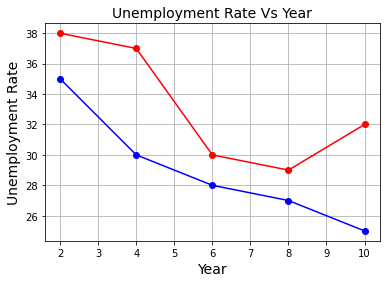

In [51]:
window_size = [2,4,6,8,10]
results_1 = [38,37,30,29,32]
results_2 = [35,30,28,27,25]
%matplotlib inline

plt.plot(window_size, results_1, color='red', marker='o')
plt.plot(window_size, results_2, color='blue', marker='o')
plt.title('Unemployment Rate Vs Year', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Unemployment Rate', fontsize=14)
plt.grid(True)
plt.show()
plt.close() 

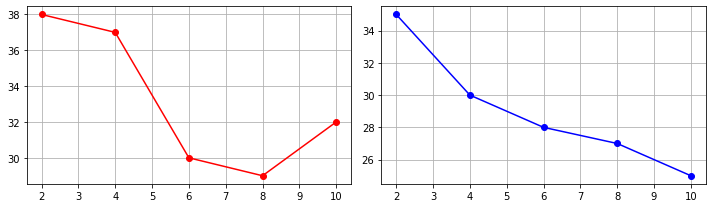

In [83]:
import numpy as np
import matplotlib.pyplot as plt

window_size = [2,4,6,8,10]
results_1 = [38,37,30,29,32]
results_2 = [35,30,28,27,25]

x1 = np.linspace(0.0, 5.0)
x2 = np.linspace(0.0, 2.0)
y1 = np.cos(2 * np.pi * x1) * np.exp(-x1)
y2 = np.cos(2 * np.pi * x2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

axes[0].plot(window_size, results_1,color='red', marker='o')
axes[1].plot(window_size, results_2,color='blue', marker='o')

axes[0].grid(True)
axes[1].grid(True)

fig.tight_layout()

# Conclusão

### OLD

In [4]:
count = 0
text = ""
with open("data/text8", 'r') as infile:
    for line in infile:
        text = process_text(line)
        
        count = + 1

In [6]:
print(text[0:50])

 anarchism originated astermabuse first usedearly 


In [6]:
sentences = word2vec.Text8Corpus('data/text8')

In [ ]:
model = Word2Vec(sentences, min_count=5)

In [36]:
model.wv.most_similar("good")

[('bad', 0.7443740963935852),
 ('poor', 0.5743762254714966),
 ('quick', 0.5488086342811584),
 ('reasonable', 0.5429285764694214),
 ('safe', 0.5324724912643433),
 ('little', 0.5284340381622314),
 ('clever', 0.5271481275558472),
 ('wrong', 0.5259556770324707),
 ('fun', 0.5209583044052124),
 ('simple', 0.5187517404556274)]

In [43]:
model.wv.most_similar(negative=['man', 'women'], positive=['king'], topn=10)

[('kiev', 0.4300565719604492),
 ('carta', 0.4149296283721924),
 ('brabant', 0.4144781827926636),
 ('umayyad', 0.40684974193573),
 ('iii', 0.39912277460098267),
 ('ducal', 0.394608736038208),
 ('cordoba', 0.39357495307922363),
 ('hohenstaufen', 0.39350447058677673),
 ('abdicates', 0.3897632956504822),
 ('achaemenid', 0.38964521884918213)]

In [29]:
model.wv.similarity('king', 'queen')

0.66290057